In [41]:
import re
from collections import defaultdict
import ast
## PLACE LOG FILE HERE
log_path = "rohan_logging.txt"

# updated patterns
patterns = {
    "prefill_receive":     re.compile(r"SHRI Prefill Request (\S+)"),
    "decode_receive":      re.compile(r"SHRI Decode Request (\S+)"),


    # "prefill_async_start": re.compile(r"ROHAN Prefill Begins Drop Select Handler: (\S+)"),
    # "prefill_async_end":   re.compile(r"ROHAN Prefill Drop Select Handler End: (\S+)"),

    
    # "decode_async_start":  re.compile(r"ROHAN Decode Drop Select Start: (\S+)"),
    # "decode_async_end":    re.compile(r"ROHAN Decode Drop Select End: (\S+)"),

    
    "send_kv_start":       re.compile(r"ROHAN Start of Send KV Caches: (\S+)"), #prefill
    "send_kv_end":         re.compile(r"ROHAN End of Send KV Caches: (\S+)"), #prefill
    "recv_kv_start":       re.compile(r"ROHAN Start of Recv KV Caches: (\S+)"), #decode
    "recv_kv_end":         re.compile(r"ROHAN End of Recv KV Caches: (\S+)"), #decode

    "phase_1": re.compile(r"ROHAN Start of execute_model \(Phase 1\): ({.*?})"), #shared by both
    "phase_2":     re.compile(r"ROHAN Model Runner Before Recv KV \(Phase 2\): ({.*?})"), #shared by both
    "phase_3": re.compile(r"ROHAN GPU Request Resume \(Phase 3\): ({.*?})"), #shared by both
    "phase_4":     re.compile(r"ROHAN Model Runner Before Send KV \(Phase 4\): ({.*?})"), #shared by both
    "phase_5":      re.compile(r"ROHAN Model Runner After Send KV \(Phase 5\): ({.*?})"), #shared by both
    "phase_6":   re.compile(r"ROHAN End of execute_model \(Phase 6\): ({.*?})"), #shared by both

    "req_start":       re.compile(r"ROHAN Start of Engine Step Request ID: (\S+)"),
    "req_end":                 re.compile(r"SHRI Finished Request ID (\S+)")
}

# regex to extract the Unix‐style float timestamp
ts_re = re.compile(r"(\d+\.\d+)")

def extract_events(log_file_path):
    prefill_events = defaultdict(list)
    decode_events = defaultdict(list)

    request_events = defaultdict(list)

    prefill_ids = set()
    decode_ids = set()

    sorted_lines = []
    with open(log_file_path, "r") as f:
        for line in f:
            # try each pattern in turn

            for name, pat in patterns.items():

                if pat.search(line):

                    # found one of your lines—now grab its timestamp

                    m = ts_re.search(line)

                    if m:

                        ts = float(m.group(1))

                        sorted_lines.append((ts, line))

                    break  # don’t test any more patterns on this line

    sorted_lines.sort(key=lambda x: x[0])

    first_time_offset = sorted_lines[0][0]
    last_time_offset = sorted_lines[-1][0]

    
    for ts, line in sorted_lines:
        # m_ts = ts_re.search(line)
        # if not m_ts:
        #     continue
        # ts = float(m_ts.group(1))
        # check each pattern
        for phase, pat in patterns.items():
            match = pat.search(line)
            # print(f"phase: {phase}, match: {match}")
            if match:
                
                if phase == "prefill_receive":
                    prefill_ids.add(match.group(1))
                elif phase == "decode_receive":
                    decode_ids.add(match.group(1))
                elif phase in ["phase_1", "phase_2", "phase_3", "phase_4", "phase_5", "phase_6"]:
                    # print(line)
                    try:
                        dict_str = match.group(1)
                        id_dict = ast.literal_eval(dict_str)
                        # print("ID_DICT: ", id_dict, type(id_dict), ts)
                        random_key_in_id_dict = next(iter(id_dict))
                        if random_key_in_id_dict in prefill_ids:
                            prefill_events[phase].append(ts)
                        elif random_key_in_id_dict in decode_ids:
                            decode_events[phase].append(ts)
                        else:
                            print("WARNING: SOMETHING IS BEING MISCLASSIFIED")
                    except Exception as e:
                        print(f"Error parsing dict: {e}")
                elif "prefill" in phase or "send_kv" in phase:
                    prefill_events[phase].append(ts)
                elif "decode" in phase or "recv_kv" in phase:
                    decode_events[phase].append(ts)
                else:
                    request_events[phase].append(ts)
                break
    return prefill_events, decode_events, request_events, first_time_offset, last_time_offset

def compute_intervals(events, first_time_offset=0):
    intervals = {}

    # # Prefill compute = from prefill_start → prefill_async_start
    # intervals['prefill_compute'] = [
    #     end - start
    #     for start, end in zip(events['prefill_start'], events['prefill_async_start'])
    # ]
    # # Prefill comm (async) = prefill_async_start → prefill_async_end
    # intervals['prefill_comm'] = [
    #     end - start
    #     for start, end in zip(events['prefill_async_start'], events['prefill_async_end'])
    # ]

    # # Decode compute = decode_start → decode_async_start
    # intervals['decode_compute'] = [
    #     end - start
    #     for start, end in zip(events['decode_start'], events['decode_async_start'])
    # ]
    # # Decode comm (async) = decode_async_start → decode_async_end
    # intervals['decode_comm'] = [
    #     end - start
    #     for start, end in zip(events['decode_async_start'], events['decode_async_end'])
    # ]

    # KV‐send comm = send_kv_start → send_kv_end
    intervals['kv_send_comm'] = [
        (start - first_time_offset, end - first_time_offset)
        for start, end in zip(events['send_kv_start'], events['send_kv_end'])
    ]
    # KV‐recv comm = recv_kv_start → recv_kv_end
    intervals['kv_recv_comm'] = [
        (start - first_time_offset, end - first_time_offset)
        for start, end in zip(events['recv_kv_start'], events['recv_kv_end'])
    ]


    # GPU/model compute = gpu_resume → execute_model_end
    intervals['phase_1_2'] = [
        (start - first_time_offset, end - first_time_offset)
        for start, end in zip(events['phase_1'], events['phase_2'])
    ]

    # GPU/model compute = gpu_resume → execute_model_end
    intervals['phase_3_4'] = [
        (start - first_time_offset, end - first_time_offset)
        for start, end in zip(events['phase_3'], events['phase_4'])
    ]



    # GPU/model compute = gpu_resume → execute_model_end
    intervals['phase_5_6'] = [
        (start - first_time_offset, end - first_time_offset)
        for start, end in zip(events['phase_5'], events['phase_6'])
    ]

    return intervals





In [93]:
import matplotlib.pyplot as plt

def plot_combined_intervals(dict1, dict2, label1="Run 1", label2="Run 2", xmin=None, xmax=None):
    fig, ax = plt.subplots(figsize=(50, 6))

    combined = {}

    # Merge both dicts with prefixes to distinguish them
    for k, v in dict1.items():
        combined[f"{label1}: {k}"] = v
    for k, v in dict2.items():
        combined[f"{label2}: {k}"] = v

    keys = list(combined.keys())

    # Hardcoded color map for known phases (extend if needed)
    color_map = {
        'kv_send_comm': 'red',
        'kv_recv_comm': 'blue',
    }

    all_starts = [start for intervals in combined.values() for start, _ in intervals]
    all_ends   = [end for intervals in combined.values() for _, end in intervals]
    xmin = xmin if xmin is not None else min(all_starts)
    xmax = xmax if xmax is not None else max(all_ends)

    yticks = []
    ylabels = []

    for i, key in enumerate(keys):
        # Strip prefix to check base name for color mapping
        base_key = key.split(": ")[-1]
        color = color_map.get(base_key, f"C{i}")  # fallback: distinct default color
        for start, end in combined[key]:
            ax.barh(y=i, width=end - start, left=start, height=0.4, color=color)
        yticks.append(i)
        ylabels.append(key)

    ax.set_xlim(xmin, xmax)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_xlabel("Time (s)")
    ax.set_title("Combined Timeline of Events")
    plt.tight_layout()
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.show()


{'kv_send_comm': [(0.009420633316040039, 0.011469125747680664), (0.07355546951293945, 0.07471656799316406), (0.16500329971313477, 0.1662290096282959), (0.2720043659210205, 0.2728452682495117), (0.5058481693267822, 0.5074357986450195), (0.570404052734375, 0.5712234973907471), (0.6568450927734375, 0.6581556797027588), (0.7302646636962891, 0.7311127185821533), (0.8055927753448486, 0.8064525127410889), (0.9551844596862793, 0.9560444355010986)], 'kv_recv_comm': [], 'phase_1_2': [(0.001615762710571289, 0.0016667842864990234), (0.06658792495727539, 0.06662964820861816), (0.13605332374572754, 0.1360950469970703), (0.2253255844116211, 0.22553467750549316), (0.2649269104003906, 0.26496458053588867), (0.3292250633239746, 0.32930517196655273), (0.49878931045532227, 0.49883413314819336), (0.5635509490966797, 0.5635888576507568), (0.6323270797729492, 0.6324176788330078), (0.649803638458252, 0.649838924407959), (0.7222802639007568, 0.7223238945007324), (0.7978267669677734, 0.7978708744049072), (0.872

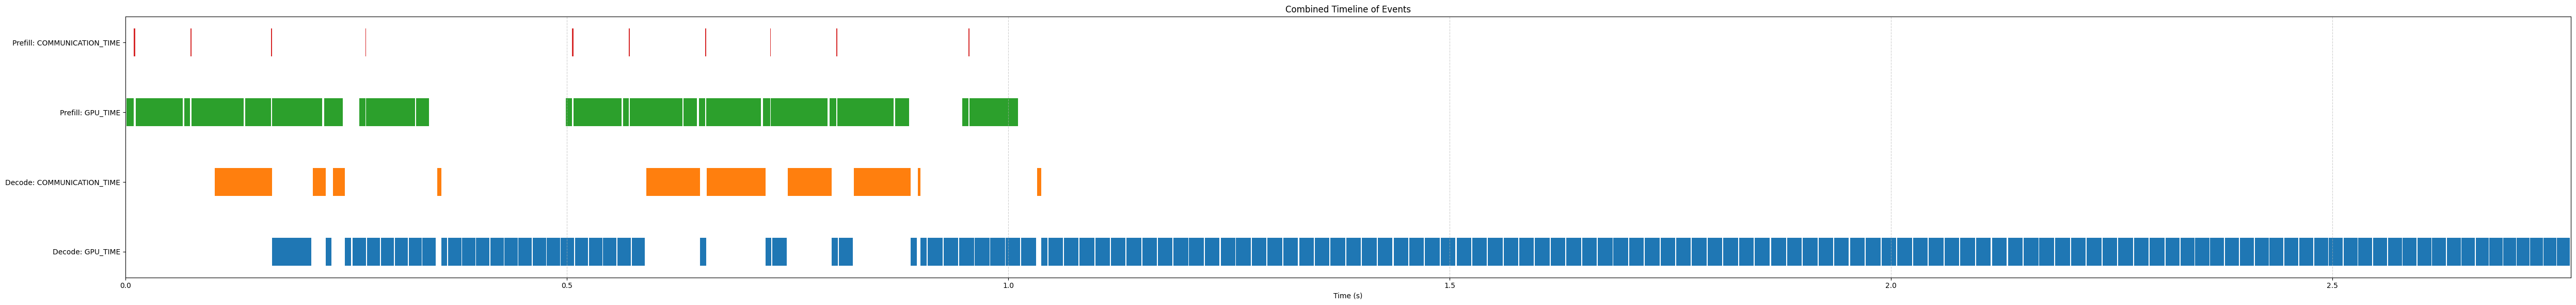

In [94]:
if __name__ == "__main__":
    prefill_events, decode_events, request_events, first_time_offset, last_time_offset = extract_events(log_path)
    # print(prefill_ids)
    # print(decode_ids)
    # print(events.keys())
    prefill_intervals = compute_intervals(prefill_events, first_time_offset)
    decode_intervals = compute_intervals(decode_events, first_time_offset)

    print(prefill_intervals)
    collapsed_prefill_intervals = {}
    collapsed_decode_intervals = {}
    collapsed_prefill_intervals["GPU_TIME"] = prefill_intervals["phase_1_2"] + prefill_intervals["phase_3_4"] + prefill_intervals["phase_5_6"]
    collapsed_prefill_intervals["COMMUNICATION_TIME"] = prefill_intervals["kv_send_comm"] + prefill_intervals["kv_recv_comm"]
    collapsed_decode_intervals["GPU_TIME"] = decode_intervals["phase_1_2"] + decode_intervals["phase_3_4"] + decode_intervals["phase_5_6"]
    collapsed_decode_intervals["COMMUNICATION_TIME"] = decode_intervals["kv_send_comm"] + decode_intervals["kv_recv_comm"]
    # print counts & average durations
    # for name, durs in intervals.items():
    #     print(name, durs)
    #     if not durs:
    #         continue
    #     avg = sum(durs) / len(durs)
    #     print(f"{name:20s}: count={len(durs):3d}, avg={avg:.6f}s, min={min(durs):.6f}s, max={max(durs):.6f}s")
    plot_combined_intervals(
        dict1=collapsed_decode_intervals,
        dict2=collapsed_prefill_intervals,
        label1="Decode",
        label2="Prefill",
        xmin=0,
        xmax=last_time_offset - first_time_offset
    )

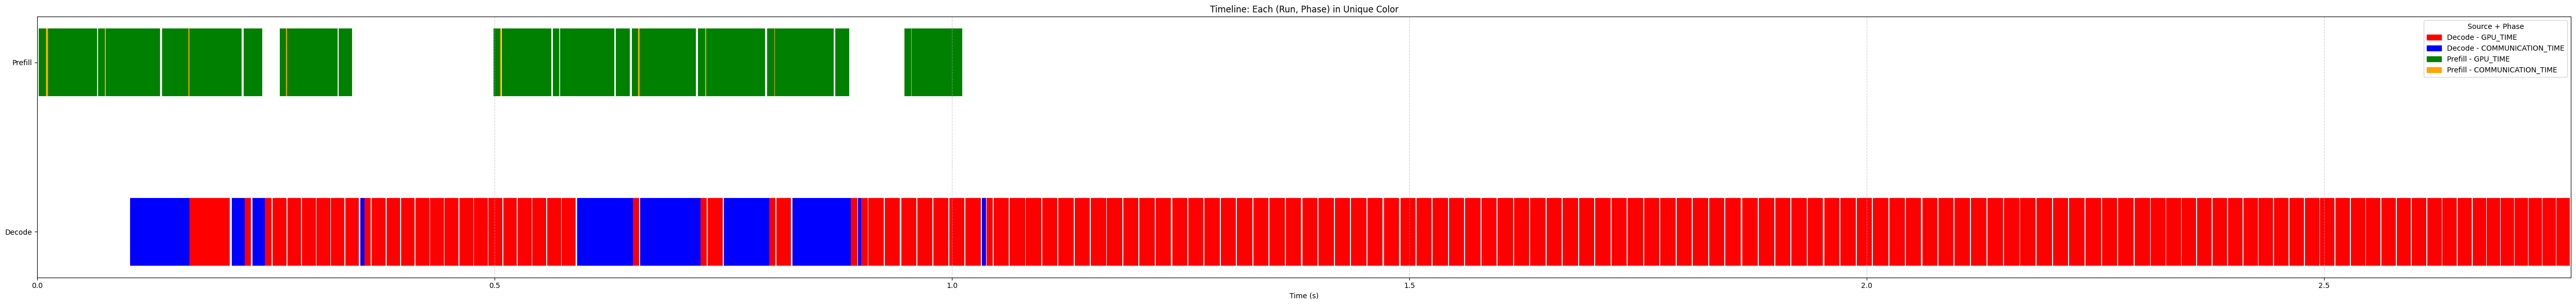

In [95]:
#not checking for overlap
import matplotlib.pyplot as plt

def plot_timeline_per_dict_with_phase_colors(dict1, dict2, label1="Baseline", label2="Optimized", xmin=None, xmax=None):
    fig, ax = plt.subplots(figsize=(50, 6))

    # Assign unique colors for each (dict, key) pair
    color_map = {
        (label1, 'GPU_TIME'): 'red',
        (label1, 'COMMUNICATION_TIME'): 'blue',
        (label2, 'GPU_TIME'): 'green',
        (label2, 'COMMUNICATION_TIME'): 'orange',
    }

    # Flatten intervals with source labels
    all1 = [(label1, k, interval) for k, intervals in dict1.items() for interval in intervals]
    all2 = [(label2, k, interval) for k, intervals in dict2.items() for interval in intervals]

    all_starts = [start for _, _, (start, _) in all1 + all2]
    all_ends   = [end for _, _, (_, end) in all1 + all2]
    xmin = xmin if xmin is not None else min(all_starts)
    xmax = xmax if xmax is not None else max(all_ends)

    # Plot Baseline on y=0, Optimized on y=1
    for label, key, (start, end) in all1:
        color = color_map.get((label, key), 'gray')
        ax.barh(y=0, width=end - start, left=start, height=0.4, color=color)

    for label, key, (start, end) in all2:
        color = color_map.get((label, key), 'gray')
        ax.barh(y=1, width=end - start, left=start, height=0.4, color=color)

    ax.set_yticks([0, 1])
    ax.set_yticklabels([label1, label2])
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel("Time (s)")
    ax.set_title("Timeline: Each (Run, Phase) in Unique Color")
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Create a manual legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for (_, _), color in color_map.items()]
    labels = [f"{run} - {phase}" for (run, phase) in color_map]
    ax.legend(handles, labels, title="Source + Phase")

    plt.show()


plot_timeline_per_dict_with_phase_colors(
        dict1=collapsed_decode_intervals,
        dict2=collapsed_prefill_intervals,
        label1="Decode",
        label2="Prefill",
        xmin=0,
        xmax=last_time_offset - first_time_offset
)